# Introduction

## Which observables do we want to reproduce with the sim
This fast simulator is here to emulate the process of observing turbulent speeds within a galaxy cluster with an instrument such as X-IFU. The goal is to produce simulations that would be provided as input to Simulation Based Inference, to produce inference on a "real" (realistic) simulation. First, let's have a look at the data as it is output from the realistic simulation.

A few imports : 

In [30]:
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
import jax.numpy as jnp
import cmasher as cmr

# I do this because I don't want to deal with making environments for this code
import sys
sys.path.append('../../src/')
from binning import LoadBinning
from structure_function import StructureFunction

## The output maps : centroid shift and broadening

Load the data from the 'output_maps' folder of the Observation5 (that I used as a reference)

In [34]:
out_censhift = jnp.array(fits.getdata('../../data/XIFU_Observation5/output_maps/output_bulk_motion.fits'))
out_broad = jnp.array(fits.getdata('../../data/XIFU_Observation5/output_maps/output_velocity.fits'))

# Actually I also use the input maps
inp_censhift = jnp.array(fits.getdata('../../data/XIFU_Observation5/input_maps/input_bulk_motion.fits'))
inp_broad = jnp.array(fits.getdata('../../data/XIFU_Observation5/input_maps/input_stdredshift.fits'))

One of these maps is the centroid shift that is observed, in a binned map. The second map corresponds to the broadening. The centroid shift is an emission-weighted average value of the speed of the gas along the line of sight, whereas the broadening is an emissio-weighted standard deviation of the speed of the gas along the line of sight.

Let's plot them:

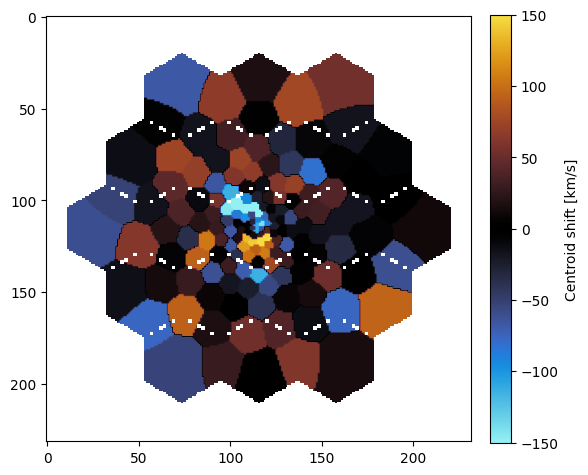

In [16]:
fig,ax = plt.subplots(1,1, figsize = (6,6))

im =ax.imshow(out_censhift, cmap = cmr.iceburn, vmin = -150, vmax = 150)
plt.colorbar(im, pad = 0.04, fraction = 0.046, label = 'Centroid shift [km/s]')

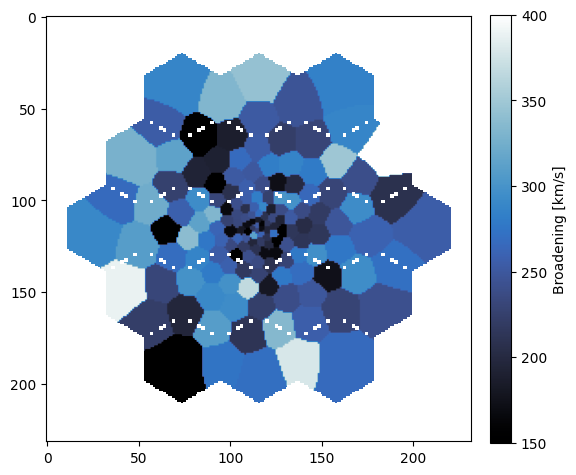

In [26]:
fig,ax = plt.subplots(1,1, figsize = (6,6))

out_broad = out_broad.at[out_broad < 0.].set(jnp.nan)

im =ax.imshow(out_broad, cmap = cmr.arctic, vmin = 150, vmax = 400)
plt.colorbar(im, pad = 0.04, fraction = 0.046, label = 'Broadening [km/s]')

## The structure function

The actual "observable" property of these fields is their second order structure function (SF). Let's plot it

In [32]:
# Load binning
binning = LoadBinning(shape = (232,232),
                 binning_file = '../../data/XIFU_Observation5/region_files/19p_region_dict.p',
                 count_map_file = '../../data/XIFU_Observation5/19p_count_image.fits')

# Get values from binning
X_pixels, Y_pixels, bin_num_pix, nb_bins, xBar_bins, yBar_bins, bin_nb_map = binning()

# Load structure function
sf = StructureFunction(bins = jnp.geomspace(3,200,20))

In [33]:
def get_sf_from_map(map_to_convert):
    
    #Initialize vector of values per bin
    vector = jnp.zeros(nb_bins)
    
    #Assign values to vector
    vector = vector.at[bin_num_pix].set(jnp.array(map_to_convert)[X_pixels, Y_pixels])
    
    #Structure function
    dists, sf_vec = sf(vector, xBar_bins, yBar_bins)
    
    return dists, sf_vec

In [35]:
dists, sf_censhift_inp = get_sf_from_map(inp_censhift)
dists, sf_censhift_out = get_sf_from_map(out_censhift)

dists, sf_broad_inp = get_sf_from_map(inp_broad)
dists, sf_broad_out = get_sf_from_map(out_broad)

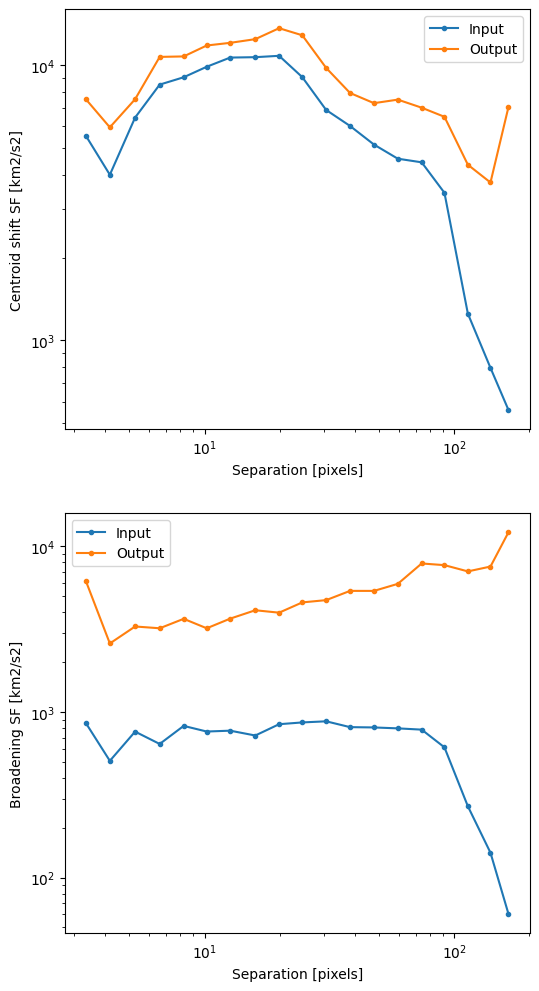

In [37]:
fig, ax = plt.subplots(2,1, figsize = (6,12))

ax[0].loglog(dists, sf_censhift_inp, label = 'Input', marker ='.')
ax[0].loglog(dists, sf_censhift_out, label = 'Output', marker ='.')
#ax[0].loglog(dists, sf_censhift_inp+2*std_diff_censhift**2, label = r'Output + $2\sigma^2$', marker ='.', color = 'tab:blue', alpha = 0.5, ls = '--')
ax[0].set_xlabel('Separation [pixels]')
ax[0].set_ylabel('Centroid shift SF [km2/s2]')
ax[0].legend()

ax[1].loglog(dists, sf_broad_inp, label = 'Input', marker ='.')
ax[1].loglog(dists, sf_broad_out, label = 'Output', marker ='.')
#ax[1].loglog(dists, sf_broad_inp+2*std_diff_broad**2, label = r'Output + $2\sigma^2$', marker ='.', color = 'tab:blue', alpha = 0.5, ls = '--')
ax[1].set_xlabel('Separation [pixels]')
ax[1].set_ylabel('Broadening SF [km2/s2]')
ax[1].legend()